In [1]:
# 1.1 - basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

# 1.2 - display settings
pd.set_option('display.max_columns', None)

In [2]:
# 2.1 - random seed
np.random.seed(42)

# 2.2 - number of rows
n = 500

# 2.3 - simulate basic demographic and sales info
data = pd.DataFrame({
    'store_id': np.random.choice([f'S{str(i).zfill(3)}' for i in range(1, 51)], n),
    'region': np.random.choice(['North', 'South', 'East', 'West'], n),
    'month': np.random.choice(pd.date_range('2023-01-01', '2024-12-01', freq='MS'), n),
    'units_sold': np.random.poisson(lam=300, size=n) + np.random.randint(0, 200, n),
    # assume selling price per unit in pence
    'price_pence': np.random.choice([60, 65, 70, 75], n),
    # cost per unit (pence)
    'cost_pence': np.random.choice([30, 35, 40, 45], n),
    # some text feedback or notes
    'notes': np.random.choice([
        'Great promotion with local event',
        'Low stock due to delivery delay',
        'High demand after advertisement',
        'Weather affected sales negatively',
        'Competition price drop nearby',
        'New flavor launch drove interest'
    ], n)
})

# 2.4 - calculate revenue, cost, and profit margin
data['revenue_pence'] = data['units_sold'] * data['price_pence']
data['cost_total_pence'] = data['units_sold'] * data['cost_pence']
data['profit_margin'] = (data['revenue_pence'] - data['cost_total_pence']) / data['revenue_pence']

# 2.5 - create a categorical target, e.g., margin band
bins = [0, 0.1, 0.2, 0.3, 1.0]
labels = ['Very low', 'Low', 'Moderate', 'High']
data['margin_band'] = pd.cut(data['profit_margin'], bins=bins, labels=labels)

data.head()

,store_id,region,month,units_sold,price_pence,cost_pence,notes,revenue_pence,cost_total_pence,profit_margin,margin_band
0,S039,West,2024-10-01,452,70,40,Low stock due to delivery delay,31640,18080,0.428571,High
1,S029,North,2024-04-01,524,75,45,Weather affected sales negatively,39300,23580,0.400000,High
2,S015,East,2023-08-01,339,60,30,High demand after advertisement,20340,10170,0.500000,High
3,S043,West,2023-04-01,384,75,35,Low stock due to delivery delay,28800,13440,0.533333,High
4,S008,North,2023-08-01,348,60,30,Great promotion with local event,20880,10440,0.500000,High


       units_sold  profit_margin
count  500.000000     500.000000
mean   401.012000       0.440160
std     61.338444       0.097207
min    257.000000       0.250000
25%    348.000000       0.357143
50%    402.000000       0.461538
75%    453.000000       0.500000
max    526.000000       0.600000
margin_band
High        465
Moderate     35
Very low      0
Low           0
Name: count, dtype: int64


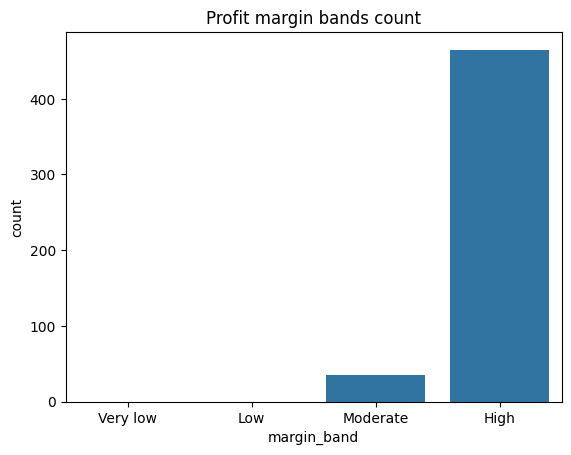

In [3]:
# 3.1 - basic stats
print(data[['units_sold', 'profit_margin']].describe())

# 3.2 - distribution of margin bands
print(data['margin_band'].value_counts())

# 3.3 - visualize margin band distribution
sns.countplot(data=data, x='margin_band', order=labels)
plt.title('Profit margin bands count')
plt.show()

In [4]:
# 4.1.1 convert month into month number or season
data['month_num'] = data['month'].dt.month

# Optional: encode season
def season_from_month(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'
    
data['season'] = data['month_num'].apply(season_from_month)

# drop columns not needed for modeling
model_data = data.drop(columns=['store_id', 'month'])  # keep others
model_data.head()

,region,units_sold,price_pence,cost_pence,notes,revenue_pence,cost_total_pence,profit_margin,margin_band,month_num,season
0,West,452,70,40,Low stock due to delivery delay,31640,18080,0.428571,High,10,Autumn
1,North,524,75,45,Weather affected sales negatively,39300,23580,0.400000,High,4,Spring
2,East,339,60,30,High demand after advertisement,20340,10170,0.500000,High,8,Summer
3,West,384,75,35,Low stock due to delivery delay,28800,13440,0.533333,High,4,Spring
4,North,348,60,30,Great promotion with local event,20880,10440,0.500000,High,8,Summer


In [5]:
# 4.2 - separate features and target
X = model_data.drop(columns=['profit_margin', 'margin_band'])
y = model_data['margin_band']  # for classification example

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

print(X_train.shape, X_test.shape)

(400, 9) (100, 9)


In [6]:
# 5.1 - column lists
numeric_features = ['units_sold', 'price_pence', 'cost_pence', 'month_num']
categorical_features = ['region', 'season']
text_feature = 'notes'

# 5.2 - preprocessors
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=100, ngram_range=(1,2)))
])

# 5.3 - column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    # for text, ColumnTransformer expects 2D input, so we select with key
    ('txt', text_transformer, text_feature)
])

In [7]:
# 5.2.1 full pipeline
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200, 
        max_depth=10, 
        random_state=42,
        n_jobs=-1
    ))
])

# 5.2.2 train
clf_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different trans

              precision    recall  f1-score   support

        High       0.94      1.00      0.97        93
    Moderate       1.00      0.14      0.25         7

    accuracy                           0.94       100
   macro avg       0.97      0.57      0.61       100
weighted avg       0.94      0.94      0.92       100



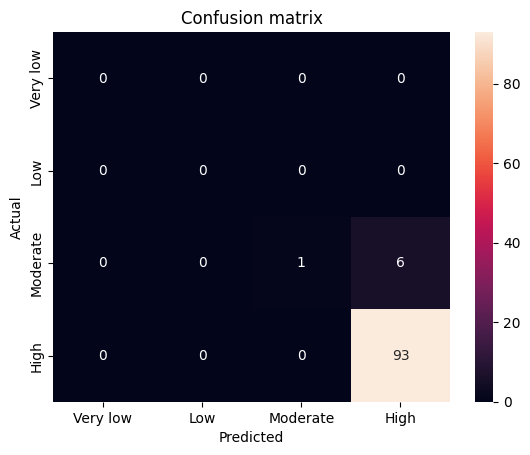

In [8]:
# 6.1 predictions
y_pred = clf_pipeline.predict(X_test)

# 6.2 classification report
print(classification_report(y_test, y_pred))

# 6.3 confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [9]:
# 7.1 - prepare target as numeric continuous
y_reg = model_data['profit_margin']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

# 7.2 - pipeline with regressor
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ))
])

reg_pipeline.fit(X_train_r, y_train_r)

# 7.3 - evaluation
y_pred_r = reg_pipeline.predict(X_test_r)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
print(f'RMSE: {rmse:.4f}')

RMSE: 0.0000


In [10]:
# 7.1 - prepare target as numeric continuous
y_reg = model_data['profit_margin']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

# 7.2 - pipeline with regressor
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ))
])

reg_pipeline.fit(X_train_r, y_train_r)

# 7.3 - evaluation
y_pred_r = reg_pipeline.predict(X_test_r)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
print(f'RMSE: {rmse:.4f}')

RMSE: 0.0000


In [11]:
# 8.1 - get feature names after preprocessing
# numeric + categorical features
num_cat_features = numeric_features + list(clf_pipeline.named_steps['preprocessor']
                                          .named_transformers_['cat']
                                          .named_steps['onehot']
                                          .get_feature_names_out(categorical_features))

# text feature names
text_feature_names = clf_pipeline.named_steps['preprocessor'] \
    .named_transformers_['txt'] \
    .named_steps['tfidf'] \
    .get_feature_names_out()

# all feature names
all_feature_names = np.concatenate([num_cat_features, text_feature_names])

# 8.2 - feature importances
importances = clf_pipeline.named_steps['classifier'].feature_importances_

# combine
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

# show top 20
print(feat_imp.head(20))

price_pence          0.258696
cost_pence           0.244365
units_sold           0.151058
month_num            0.076201
region_North         0.026808
season_Autumn        0.026623
region_West          0.023388
region_South         0.022721
region_East          0.018638
season_Spring        0.018543
season_Winter        0.018114
season_Summer        0.015671
price                0.004802
drop nearby          0.004537
drop                 0.003908
great promotion      0.003835
competition price    0.003777
demand               0.003756
demand after         0.003374
price drop           0.003018
dtype: float64


In [12]:
# 10.1 - save model if desired
import joblib
joblib.dump(clf_pipeline, 'tizer_margin_classifier.pkl')

# 10.2 - save processed feature importance
feat_imp.head(50).to_csv('feature_importances.csv')

# 10.3 - save dataset snapshot
data.to_csv('tizer_sales_demo.csv', index=False)